In [1]:
import os
import sys
import numpy as np
import torch
from torchvision import datasets, transforms
from htmresearch.frameworks.pytorch.mnist_sparse_experiment import \
  MNISTSparseExperiment
from htmresearch.frameworks.pytorch.model_utils import evaluateModel
from htmresearch.frameworks.pytorch.benchmark_utils import (
  register_nonzero_counter, unregister_counter_nonzero)
from tabulate import tabulate

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [2]:
%matplotlib inline
def analyzeDutycyclePruning(path, params, minW, minD):

    # Dataset transformations used during training. See mnist_sparse_experiment.py
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))])

    # Initialize MNIST test dataset for this experiment
    test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(params["datadir"], train=False, download=True,
                   transform=transform),
    batch_size=params["test_batch_size"], shuffle=True)

    # Load pre-trained model and evaluate with test dataset
    model = torch.load(os.path.join(path, "model.pt"), map_location="cpu")
    model.pruneWeights(minW)
    model.pruneDutycycles(minD)

    # Collect nonzero
    nonzero = {}
    register_nonzero_counter(model, nonzero)
    results = evaluateModel(model, test_loader)
    unregister_counter_nonzero(model)
    table = pd.DataFrame.from_dict(nonzero)
    table = pd.DataFrame({"nonzero weight": table.xs("weight")})
    table.dropna(inplace=True)
    table.drop(["input", "output"], inplace=True)
    print(tabulate(table, headers='keys', tablefmt='fancy_grid', numalign="right"))

    for k, v in model.named_buffers():
        if 'dutyCycle' in k:
            dutyCycle = v.view(-1).numpy()
            dutyCycle[dutyCycle<=minD] = 0
            print k,", min:", dutyCycle.min(), \
                    ", max:",dutyCycle.max(), \
                    ", nonzero:", len(dutyCycle.nonzero()[0])
            plt.figure()
            pd.Series(dutyCycle).plot(kind='hist', title=k, bins=100)

    return model, results["accuracy"]

Before prunning
╒═════════════════════════╤══════════════════╕
│                         │   nonzero weight │
╞═════════════════════════╪══════════════════╡
│ cnnSdr.cnnSdr0.cnn      │             7500 │
├─────────────────────────┼──────────────────┤
│ cnnSdr.cnnSdr1.cnn      │           225000 │
├─────────────────────────┼──────────────────┤
│ fc                      │            30000 │
├─────────────────────────┼──────────────────┤
│ linearSdr.linearSdr1.l1 │           432000 │
╘═════════════════════════╧══════════════════╛
cnnSdr.cnnSdr0.dutyCycle , min: 0.00025 , max: 0.296868 , nonzero: 30
cnnSdr.cnnSdr1.dutyCycle , min: 0.469444 , max: 0.810401 , nonzero: 30
linearSdr.linearSdr1.dutyCycle , min: 0.0 , max: 0.784193 , nonzero: 294


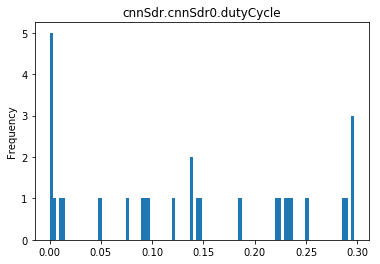

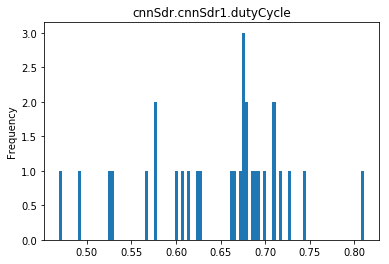

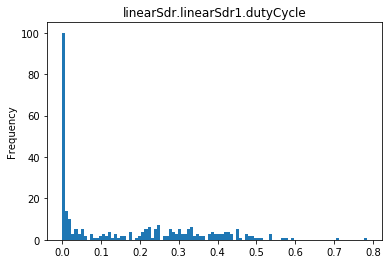

In [3]:
sys.argv = ['-c', 'experiments_paper.cfg']
suite = MNISTSparseExperiment()
suite.parse_opt()
suite.parse_cfg()
path = suite.get_exp("sparseCNN2")[0]
results = suite.get_exps(path=path)
print "Before prunning"
model, accuracy = analyzeDutycyclePruning(path=path, 
                                          params=suite.get_params(results[0]), 
                                          minW=0.0, 
                                          minD=0.0)

In [4]:
dc = model.linearSdr.linearSdr1.dutyCycle
w = model.linearSdr.linearSdr1.l1.weight

print "accuracy:", accuracy
print "w.nonzero:", torch.nonzero(w).size()[0]
print "dc.nonzero:", torch.nonzero(dc).size()[0]

accuracy: 0.9857
w.nonzero: 43200
dc.nonzero: 294


After weight prunning
╒═════════════════════════╤══════════════════╕
│                         │   nonzero weight │
╞═════════════════════════╪══════════════════╡
│ cnnSdr.cnnSdr0.cnn      │             4730 │
├─────────────────────────┼──────────────────┤
│ cnnSdr.cnnSdr1.cnn      │            63360 │
├─────────────────────────┼──────────────────┤
│ fc                      │            17910 │
├─────────────────────────┼──────────────────┤
│ linearSdr.linearSdr1.l1 │           124630 │
╘═════════════════════════╧══════════════════╛
cnnSdr.cnnSdr0.dutyCycle , min: 0.0 , max: 0.30175 , nonzero: 21
cnnSdr.cnnSdr1.dutyCycle , min: 0.469444 , max: 0.810401 , nonzero: 30
linearSdr.linearSdr1.dutyCycle , min: 0.0 , max: 0.784193 , nonzero: 196


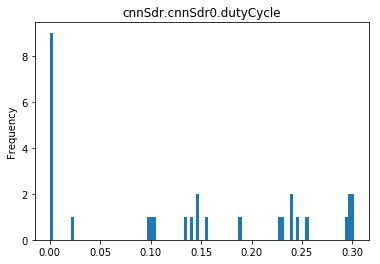

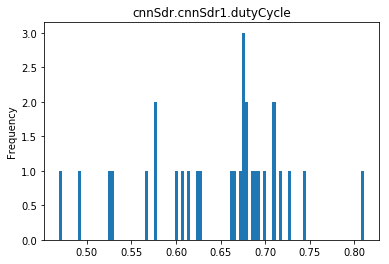

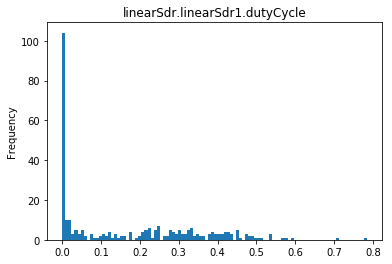

In [5]:
print "After weight prunning"
model, accuracy = analyzeDutycyclePruning(path=path,
                                          params=suite.get_params(results[0]), 
                                          minW=0.03, 
                                          minD=0.01)


In [6]:
dc = model.linearSdr.linearSdr1.dutyCycle
w = model.linearSdr.linearSdr1.l1.weight

print "accuracy:", accuracy
print "w.nonzero:", torch.nonzero(w).size()[0]
print "dc.nonzero:", torch.nonzero(dc).size()[0]

accuracy: 0.9836
w.nonzero: 12463
dc.nonzero: 196
